# A Principled Bayesian Inference of a Fluorescence Calibration Factor

© 2019 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [1]:
import numpy as np
import pandas as pd
import pystan 
import mwc.viz
import mwc.stats
import mwc.bayes
import scipy.stats
import matplotlib.pyplot as plt
import bokeh.io
import bokeh.plotting
import bokeh.palettes
import multiprocessing as mp
import joblib
import mwc.viz
import tqdm
seed = np.random.seed(666)
colors, colors_list = mwc.viz.bokeh_theme() 
bokeh.io.output_notebook()
%load_ext stanmagic

Loading BokehJS ...

In this notebook, we lay out a principled workflow for the parameter estimation of a fluorescence calibration factor. This notebook covers the inference of the calibratoin factor from a single measurement. A principled analysis of a hierarchical approach will be written at a later date. 

## Writing A Physical Model

It has become trivial in the era of molecular biology to label your favorite protein with a reporter that fluoresces at your favorite wavelength. Similarly, single-cell and single-molecule microscopy has become commonplace, making precise measurement of total cell fluorescence and/or localization a relatively painless procedure. However, it is still remarkably difficult to translate that precise measurement of fluorescence into the absolute copy number of your protein. 

By measuring the fluctuations in intensity between a mother/daughter pair after cell division, we can back calculate how bright a single molecule of interest is in arbitrary unitls, permitting the relatively easy calculation of protein copy number. We operate under the assumption that protein degradation is negligible and that protein production is ceased immediately before division. Using these assumptions, we can say that the total intensity of a given cell $I_\text{tot}$ is related to the number of fluorescent proteins and their relative brightness,

$$
I_\text{tot} = \alpha N_\text{tot}, \tag{1}
$$

where $N_\text{tot}$ is the total number of proteins and $\alpha$ is the brightness of a single fluorophore. Assuming there is no more production or deradation, we can relate the intensity of the mother cell to the daughter cells by dictating that the fluorescence must be conserved,

$$
I_\text{tot} = I_1 + I_2 = \alpha (N_1 + N_2), \tag{2}
$$

where we have used $I_1$ and $I_2$ to represent the total intensity of daughter cells 1 and 2. By looking at the fluctuations in intensity between the two daughter cells, followed by invocation of the mean and variance of the Binomial distribution, we arrive at the simple relation that

$$
\langle (I_1 - I_2)^2 \rangle = \alpha I_\text{tot}. \tag{3}
$$

Of course, lumped in with $\alpha$ is all of the features of the detector, fluorophore quantum efficiency, and other minutae of measurement. While incorporating these details into the generative model building is the proper thing to do, I know from experience in these experiments and quantitative biological. microscopy in general that the noise in these measurements is much smaller than the noise of the biological system. To this end, we will neglect them for simplicity. 

## Building a Generative Statistical Model

The posterior probability distribution for our parameter of interest $\alpha$ is given by Bayes' theorem as

$$
g(\alpha\,\vert\,[I_1, I_2]) \propto f([I_1, I_2]\,\vert\, \alpha)g(\alpha)
\tag{4},
$$

where I have used $g$ and $f$ to denote probability density functions over parameters and data, respectively. As $I_1$ and $I_2$ are related to each other (through Eq. 2), the likelihood $f([I_1, I_2]\,\vert\, \alpha)$ can be rewritten in the form,

$$
f([I_1, I_2]\,\vert\,\alpha) = f([I_1]\,\vert\, \alpha, [I_2]).\tag{5}
$$

Ultimately, we would like to translate the observed intensity into the nubmer of fluorescent proteins in the cell. Using Eq. 1 and the change-of-variables formula, Eq. 5 can be written in terms of $N_1$ as

$$
f([I_1]\,\vert\, \alpha, [I_2]) = f([N_1]\,\vert\,\alpha, [I_2]) {d N_1 \over d I_1} = {1 \over \alpha^k}f([N_1]\,\vert\,\alpha,[I_2]),\tag{6}
$$

where $k$ is the number of observed division events in the set of observed intensities $[I_1, I_2]$. 

The number of proteins present in the arbitrarily chosen daughter cell 1 ($N_1$) should be binomial distributed with $N_{tot}$ proteins in the mother cell. As such, the functional form of our likelihood can be written as

$$
f([N_1]\,\vert\,\alpha,[I_2]) = {1 \over \alpha^k}\prod\limits_{i=1}^k {\Gamma\left({I_{1,i} + I_{2,i} \over \alpha} + 1\right) \over \Gamma\left({I_1 \over \alpha} + 1\right) \Gamma\left({I_2 \over \alpha} + 1\right)} 2^{-{I_1 + I_2 \over \alpha}},\tag{7}
$$

where Gamma functions are used to avoid factorials of continuous variables. Note here we have used the simplifying assumption that the proteins are partitioned between the two proteins with an equal probability, $p = 1/2$. This is a fair approximation as the repressors to which the fluorescent proteins are covalently bound are always bound to the DNA and therefore are partitioned via segregation of the chromosomes. 


With the likelihood in hand, we are now assigned the task of setting a prior for $\alpha$, which will be verified by prior predictive checks. This is certainly not an obvious endeavor as we do not have a good intuitoin for how bright a single fluorophore should be. However, we do know some limits. For example, it is not possible for the fluoropohore to have a negative value as the detector returns unsigned integeters per pixel as the readout. We also know that our resolution is diffraction limited meaning in the extreme case in which the repressors are frozen in a specific point, their fluorescence will be detected across several pixels. In our system, the interpixel distance of the camera is on the order of 50 nm / pixel meaning that a single fluorophore will have a diameter of 4 - 5 pixels (assuming the extreme scenario in which diffusion of the fluorophore is much slower than the frame rate of our camera). With a bit-depth of 12, the maximum value that a pixel can be assigned is $2^{12} - 1 = 4095$ arbitrary units. Thus, the maximum brightness of a single fluorophore that can be detected on our system is $ 4 \times 4095 \approx 1.5\times 10^4$ a.u. /molecule. This, of course is a large upper bound and in our system the fluorescence will be below this value. However, we can use these bounds to  define a prior. As flat priors are difficult to sample and a uniform prior is not appropriate, we can assign a log-normal prior centered at $\approx 5$ (~200 [a.u.]) with a scale parameter of 3.

## Prior Predictive Checks
The best way to check if this choice of prior is reasonable is to draw $N$ values from this prior distribution and use $\alpha$ to generate a data set of $M$ values for $I_1$ based on a set of $M$ protein copy numbers. To start, we will define a set protein copy numbers $N_1$ that cover physiologically reasonable values of intenisities.

In [5]:
# Define the set of copy numbers. 
M = 500 
N1 = np.random.gamma(10, 10, M).astype(int) # Gamma distributed to mimic bursty gene expression

We can now make $N$ draws out of the prior distribution for $\alpha$ and compute the observed intensities $I_1$. We'll make this as a data frame for use later. 

In [73]:
# Make N draws out of a lognormal distribution for alpha. 
N = 500
alpha_draws = np.random.lognormal(5, 2, N)

# Compute the intensities. 
n, a = np.meshgrid(N1, alpha_draws)
I1 = n * a

# Make the dataframe. 
ppc_df = pd.DataFrame(np.array([I1.flatten(), n.flatten(), a. flatten()]).T, 
                     columns=['I1', 'N1', 'alpha_true'])

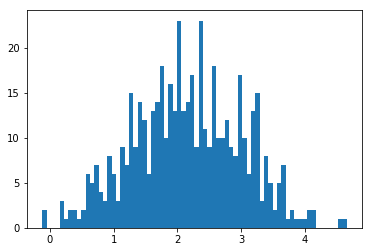

In [76]:
_ = plt.hist(np.log10(alpha_draws), bins=70)



In [22]:
# Compute percentiles of the data.
percentiles = [0.99, 0.95, 0.75, 0.5, 0.25, 0.1, 0.05, 0.01]
cmap = bokeh.palettes.Purples9
ax = bokeh.plotting.figure(width=600, height=400, 
                          x_axis_label='cell intensity [a.u.]',
                         y_axis_label='cumulative distribution',
                         x_axis_type='log')

percentile_df = pd.DataFrame([])
for g, d in ppc_df.groupby(['N1']):
    x = np.sort(d['I1'].values) 
    y = np.linspace(0, 1, len(d))
    ax.line(x, y, line_width=0.5, color=colors_list[0])

bokeh.io.show(ax)

These distributions look pretty good -- most of the generated intensities are between $10^2$ and $10^7$ a.u. per cell which is in line with what I would see in the extremes of my experiments. There s also barely any density below $1$ a.u. / cell, which is what we would want to see during the prior predictive checks. 

Satisfied with our choice of prior, we can now define the model using Stan, as given in the cell below. 

In [79]:
%%stan -v simple
functions{
    /** 
    * Approximate the Binomial distirubution for continuous variables 
    * as a ratio of Gamma functions 
    * 
    * @param I1: Observed fluorescence of daughter cell 1. 
    * @param I2: Observed fluorescence of daughter cell 2.
    * @param alpha: Fluorescenc calibration factor in units of a.u. / molecule
    * @param N: Total number of measurements 
    **/
    real GammaApproxBinom_lpdf(vector I1, vector I2, real alpha) {
        return sum(-log(alpha) + lgamma(((I1 + I2) ./ alpha) + 1) - lgamma((I1 ./ alpha) + 1) - lgamma((I2 ./ alpha) + 1) - ((I1 + I2) ./ alpha) * log(2));
    } 

}
     
data {
    int<lower=0> N; // Number of data points
    vector<lower=0>[N] I1; // Observed fluorescence of daughter cell 1
    vector<lower=0>[N] I2; // Observed fluorescence of daughter cell 2
}


parameters {
    // Generate entered parameters
    real<lower=0> alpha;
}


model {     
    alpha ~ lognormal(5, 2);
    I1 ~ GammaApproxBinom(I2, alpha);  
}


Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in simple object.
Type simple in a cell to see a nicely formatted code output in a notebook
     ^^^^^^
Access model compile output properties
simple.model_file -> Name of stan_file [None]
simple.model_name -> Name of stan model [None]
simple.model_code -> Model code [functions{     /**   ....]


In [8]:
%%stan -v proper
data {
    int<lower=1> N;
    vector<lower=0>[N] I1;
    vector<lower=0>[N] I2;
}

parameters {
    vector<lower=0>[N] n_tot;
    vector<lower=0>[N] n1;
    real<lower=0> alpha;
    real<lower=0> sigma;
}

model {
    vector[N] n2;
    n_tot ~ lognormal(3, 3);
    sigma ~ normal(0, 1);
    alpha ~ lognormal(3, 3);
    n1 ~ normal(n_tot/2, n_tot/4);
    n2 = n_tot - n1;
    I1 ~ normal(alpha * n1, sigma);
    I2 ~ normal(alpha * n2, sigma);
}

Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in proper object.
Type proper in a cell to see a nicely formatted code output in a notebook
     ^^^^^^
Access model compile output properties
proper.model_file -> Name of stan_file [None]
proper.model_name -> Name of stan model [None]
proper.model_code -> Model code [data {     int<lower ....]


In [80]:
# Compile the model 
model = pystan.StanModel(model_code=simple.model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_25a6eb75582f6e268f05e929eb488212 NOW.
/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpiqk9r342/stanfit4anon_model_25a6eb75582f6e268f05e929eb488212_675063978367436101.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


## Computational Tractability

Our next step in the workflow is to ensure that our model is well specified and computationally accessible. To do so, we perform [Simulation Based Calibration]() as put forward by Talts. et al. in 2018. To do so, given the draws from the prior, we generate $M$ simulated data sets for the partitioning with $N$ divisions each, where the intensity is dicted by the draw from the $\alpha$ prior distribution. Using this data set, we then perform inference on these data and compare the data-averaged posterior distribution for $\alpha$ to the true prior distribution. If everything works as expected, we should recover the prior distribution and have uniformly distributed rank statistics. In addition, we can check the degree to which the prior distribution shrinks (shrinkage) as well as the $z-$score, which quantifies how accurately the posterior captures the model configuration.

To permit direct comparison between inferential runs, we will use the same randomly generated protein copy numbers and only change the measured intensity $I$. 

In [88]:
# Define the number of divisions
M = 100
n_tot = np.random.gamma(10, 10, M).astype(int)
n1 = np.random.binomial(n_tot, p=0.5)
n2 = n_tot - n1

# Define a function to evaluate a single run. 
def sbc(alpha):
        df = pd.DataFrame([])
        # Compute intensities
        I1 = n1 * alpha
        I2 = n2 * alpha
    
        # Perform inference. 
        samples = model.sampling(dict(N=M, I1=I1, I2=I2), n_jobs=1, 
                                control=dict(adapt_delta=0.99), iter=5000)
        samples = samples.to_dataframe()
    
        # Compute the statistics. 
        samples['alpha'] = np.exp(samples['alpha'])
        mean_alpha = np.mean(samples['alpha'])
        shrinkage = 1 - (np.var(samples['alpha']) / np.var(alpha_draws))
        z_score = (mean_alpha - alpha) / np.std(samples['alpha'])
        df = df.append(dict(alpha_true=alpha, mean_alpha=mean_alpha, 
                           shrinkage=shrinkage, z_score=z_score), ignore_index=True)
        return df

In [ ]:
result = joblib.Parallel(n_jobs=-1)(joblib.delayed(sbc)(a) for a in tqdm.tqdm(alpha_draws))



  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:00<01:24,  5.89it/s]

  2%|▏         | 8/500 [00:24<09:39,  1.18s/it]

  2%|▏         | 9/500 [00:25<07:14,  1.13it/s]

  2%|▏         | 10/500 [00:25<05:54,  1.38it/s]

  2%|▏         | 11/500 [00:26<06:26,  1.27it/s]

  2%|▏         | 12/500 [00:45<50:07,  6.16s/it]

  3%|▎         | 13/500 [00:46<37:37,  4.64s/it]

  3%|▎         | 14/500 [00:48<32:45,  4.05s/it]

  3%|▎         | 15/500 [00:49<24:18,  3.01s/it]

  3%|▎         | 16/500 [01:05<56:40,  7.03s/it]

  3%|▎         | 17/500 [01:07<44:31,  5.53s/it]

  4%|▎         | 18/500 [01:09<34:47,  4.33s/it]

  4%|▍         | 19/500 [01:10<27:23,  3.42s/it]

  4%|▍         | 20/500 [01:28<1:01:30,  7.69s/it]

  4%|▍         | 21/500 [01:29<45:19,  5.68s/it]  

  4%|▍         | 22/500 [01:30<35:39,  4.48s/it]

  5%|▍         | 23/500 [01:34<32:24,  4.08s/it]

  5%|▍         | 24/500 [01:49<1:00:19,  7.60s/it]

  5%|▌         | 25/500 [01:50<42:27,  5.36s/it]  

  

In [ ]:
sbc_df = pd.concat(result)
# Compute the rank statistic. 
rank = [np.sum(sbc_df['mean_alpha'] < a) for a in alpha_draws]
sbc_df['rank'] = rank
sbc_df.to_csv('../../data/sbc_calibration_factor.csv', index=False)

In [ ]:
ax = bokeh.plotting.figure(width=600, height=400, x_axis_label='rank statistic', y_axis_label='cumulative distribution')
ax.step(np.sort(sbc_df['rank']), np.linspace(0, 1, len(sbc_df)), color=colors['dark_purple'])
bokeh.io.show(ax)

In [ ]:
p = bokeh.plotting.figure(width=600, height=400, 
                          x_axis_label='shrinkage', y_axis_label='z-score')
p.circle(sbc_df['shrinkage'], sbc_df['z_score'])
bokeh.io.show(p)

In [45]:
sbc_df

alpha_true     mean_alpha      shrinkage    z_score  rank
0    153.876825  2.617824e+106 -1.794830e+210   0.015822   119
0     12.450470   5.242978e+06  -1.078365e+10   0.040881    73
0      5.918984   7.670688e+02  -3.095841e-03   0.615360    57
0    578.097923            inf            NaN        NaN   139
0     26.626680   4.636327e+19  -5.220745e+36   0.016430    89
0      4.734470   1.786983e+02   9.797682e-01   0.990312    52
0     26.522282   3.614281e+15  -4.132964e+27   0.045522    89
0      7.349795   3.759056e+03  -4.350425e+01   0.455364    62
0    116.976408   1.381582e+79 -5.000135e+155   0.015820   116
0     77.812402   9.435865e+51 -1.294961e+101   0.021232   105
0     99.953313   4.421013e+71 -5.122560e+140   0.015816   112
0      3.046484   2.548814e+01   9.998729e-01   1.611833    39
0      0.358566   1.456417e+00   1.000000e+00  13.169752     0
0    121.301755   1.089360e+93 -1.934195e+183   0.020056   116
0      4.803837   1.958899e+02   9.670615e-01   0.852526    53
0      0.662044   1.997057e+00   1.000000e+00   6.761948     0
0    196.866867  3.862947e+143 -3.890026e+284   0.015859   124
0     11.059471   3.248015e+06  -6.131924e+09   0.033585    73
0     86.254838   5.241803e+67 -7.203985e+132   0.015813   107
0     60.279704   5.837743e+40  -7.914594e+78   0.016802   100
0      5.222744   3.113665e+02   9.114732e-01   0.833140    54
0     55.636878   6.629546e+38  -5.630434e+74   0.022623   100
0    811.471542            inf            NaN        NaN   142
0      1.208625   3.581831e+00   9.999997e-01   3.365352     8
0     84.279117   4.566060e+70 -5.466184e+138   0.015814   107
0    150.999153  1.342638e+107 -4.717102e+211   0.015829   119
0      8.608675   3.202572e+04  -7.798632e+04   0.092833    69
0     48.956783   9.946771e+31  -2.003917e+61   0.017992    98
0      3.436928   4.079613e+01   9.994562e-01   1.297256    40
0      0.881538   2.509649e+00   9.999999e-01   4.799215     0
..          ...            ...            ...        ...   ...
0     24.454592   8.342467e+16  -1.812007e+31   0.015869    84
0     36.609826   8.590026e+25  -1.414703e+49   0.018492    95
0     22.664453   4.748455e+13  -1.336651e+24   0.033256    83
0    620.246895            inf            NaN        NaN   140
0      3.247600   3.247654e+01   9.997337e-01   1.450212    39
0    248.423209  7.989149e+187           -inf   0.000000   127
0     47.727550   1.397309e+33  -5.089799e+63   0.015859    98
0     54.123941   3.337601e+35  -6.722719e+67   0.032960    99
0   1015.271160            inf            NaN        NaN   144
0    279.622857  3.371081e+206           -inf   0.000000   127
0     10.004151   1.113110e+06  -1.818749e+09   0.021134    71
0    131.113809  6.550479e+101 -1.121559e+201   0.015838   117
0     23.566493   7.270027e+13  -3.176172e+24   0.033030    83
0      1.313162   3.961915e+00   9.999995e-01   3.100141    15
0      5.794891   6.099343e+02   2.784212e-01   0.575871    57
0      1.290250   3.901827e+00   9.999995e-01   3.088744    13
0      5.422759   3.832400e+02   8.831294e-01   0.894869    55
0    142.414035  3.751627e+102 -3.599512e+202   0.016011   119
0     47.185783   7.815710e+34  -1.601275e+67   0.015815    98
0      2.805492   2.016831e+01   9.999300e-01   1.680277    39
0      9.179449   4.066233e+04  -1.472819e+04   0.271228    69
0      0.435489   1.574780e+00   1.000000e+00  10.752563     0
0      7.575871   5.372213e+03  -8.609306e+01   0.465456    62
0     89.926019   6.335752e+66 -1.052433e+131   0.015814   108
0    449.100699            inf            NaN        NaN   139
0     10.866460   3.200187e+05  -2.246139e+06   0.172891    73
0     11.524927   8.397294e+05  -1.329992e+07   0.186440    73
0    602.801781            inf            NaN        NaN   139
0      1.149402   3.343021e+00   9.999997e-01   3.480648     3
0     90.885650   4.856412e+68 -6.119569e+134   0.015896   108

[500 rows x 5 columns]

(array([86.,  3.,  4.,  2.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([2.96488903e-02, 3.95394404e+02, 7.90759160e+02, 1.18612392e+03,
        1.58148867e+03, 1.97685343e+03, 2.37221818e+03, 2.76758294e+03,
        3.16294769e+03, 3.55831245e+03, 3.95367720e+03, 4.34904196e+03,
        4.74440671e+03, 5.13977147e+03, 5.53513623e+03, 5.93050098e+03,
        6.32586574e+03, 6.72123049e+03, 7.11659525e+03, 7.51196000e+03,
        7.90732476e+03, 8.30268951e+03, 8.69805427e+03, 9.09341902e+03,
  

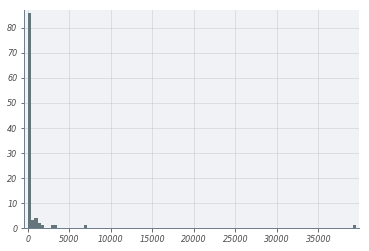

In [24]:

plt.hist(sbc_df['mean_alpha'], bins=100)
# plt.xscale('log')

In [23]:
output = joblib.Parallel(n_jobs=mp.cpu_count())(joblib.delayed(sbc)(a) for a in alpha_draws)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-6662d88c9822>", line 1, in <module>
    output = joblib.Parallel(n_jobs=mp.cpu_count())(joblib.delayed(sbc)(a) for a in alpha_draws)
  File "/anaconda3/lib/python3.6/site-packages/joblib/parallel.py", line 996, in __call__
    self.retrieve()
  File "/anaconda3/lib/python3.6/site-packages/joblib/parallel.py", line 899, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/anaconda3/lib/python3.6/site-packages/joblib/_parallel_backends.py", line 517, in wrap_future_result
    return future.result(timeout=timeout)
  File "/anaconda3/lib/python3.6/concurrent/futures/_base.py", line 427, in result
    self._condition.wait(timeout)
  File "/anaconda3/lib/python3.6/threading.py", line 295, in wait
    waiter.acquire()
KeyboardInterrupt

During handling o

KeyboardInterrupt: 